In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
from pathlib import Path
import os

# Path to the data directory
data_dir = Path("../data/captchas/train/")

# Get list of all JPEG images
images = sorted(
    [str(p) for p in data_dir.glob("*") if p.suffix.lower() in [".jpg", ".jpeg"]]
)

if len(images) == 0:
    raise ValueError(f"Aucune image trouvée dans {data_dir.resolve()}")

# Extract labels (part after '_', before extension)
labels = [
    os.path.basename(img).split("_", 1)[1].rsplit(".", 1)[0]
    for img in images
]

# Set of unique characters
characters = set(char for label in labels for char in label)

print("Number of images found:", len(images))
print("Number of labels found:", len(labels))
print("Number of unique characters:", len(characters))
print("Characters present:", sorted(characters))

# Batch size
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 50

# Downsampling factor (3 pooling layers → 8)
downsample_factor = 8

# Maximum length of any captcha
max_length = max(len(label) for label in labels)


Number of images found: 8501
Number of labels found: 8501
Number of unique characters: 40
Characters present: ['2', '6', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'm', 'n', 'p', 'r', 's', 't', 'u', 'v', 'x', 'z']


In [3]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    mask_token=None,
    invert=True,
)


In [4]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


In [5]:

def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [7]:
# ================================
# DATASETS TF.DATA (ADAPTÉ)
# ================================

AUTOTUNE = tf.data.AUTOTUNE

# -------- Training dataset --------
train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(buffer_size=len(x_train), seed=42, reshuffle_each_iteration=True)
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# -------- Validation dataset --------
validation_dataset = (
    tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    .map(encode_single_sample, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


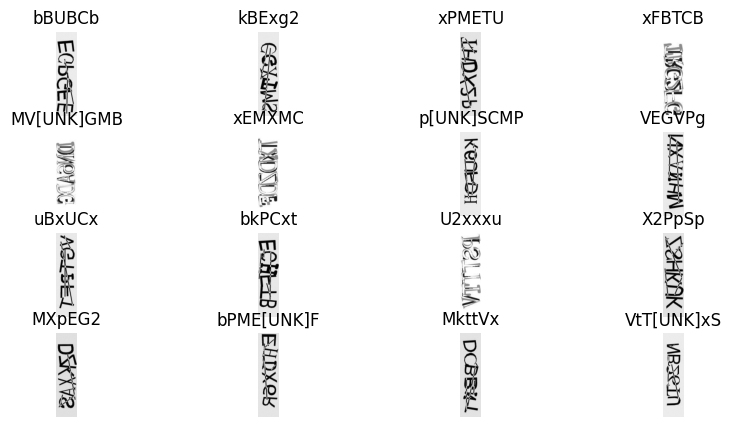

In [8]:
# ================================
# VISUALISATION DES DONNÉES D'ENTRAÎNEMENT (ADAPTÉE)
# ================================

_, ax = plt.subplots(4, 4, figsize=(10, 5))

for batch in train_dataset.take(1):
    images = batch["image"]   # images prétraitées
    labels = batch["label"]   # labels encodés

    for i in range(16):
        # Image telle que vue par le modèle
        img = (images[i] * 255).numpy().astype("uint8")

        # Décodage du label
        label = tf.strings.reduce_join(
            num_to_char(labels[i])
        ).numpy().decode("utf-8")

        # Affichage (PAS de transpose)
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

plt.show()


=========================================

In [18]:
# ================================
# FULL WORKING OCR CAPTCHA (CTC) — FINAL FIX
# ================================

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.AUTOTUNE

# ================================
# DATA
# ================================
data_dir = Path("../data/captcha_images_v2/")
images = sorted([str(p) for p in data_dir.glob("*.png")])
labels = np.array([os.path.basename(p).replace(".png", "") for p in images])

characters = sorted(set(c for l in labels for c in l))

batch_size = 16
img_width = 200
img_height = 50
downsample_factor = 4
max_length = max(len(l) for l in labels)

# ================================
# TRAIN / VAL SPLIT
# ================================
lengths = np.array([len(l) for l in labels])

x_train, x_valid, y_train, y_valid = train_test_split(
    np.array(images),
    labels,
    test_size=0.1,
    random_state=42,
    stratify=lengths
)

# ================================
# CHAR ↔ INT (IMPORTANT: START AT 1)
# ================================
char_to_num = layers.StringLookup(
    vocabulary=characters,
    mask_token=None,
    num_oov_indices=0
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
    mask_token=None
)

# ================================
# OPENCV PREPROCESS
# ================================
def preprocess_with_opencv(img_path):
    path = img_path.numpy().decode()
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))

    img = cv2.adaptiveThreshold(
        img, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )

    kernel = np.ones((2, 2), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, -1)
    img = np.transpose(img, (1, 0, 2))  # width = time

    return img

def encode_sample(img_path, label):
    img = tf.py_function(preprocess_with_opencv, [img_path], tf.float32)
    img.set_shape((img_width, img_height, 1))

    label = char_to_num(tf.strings.unicode_split(label, "UTF-8"))
    label = tf.cast(label, tf.int32)

    # PAD WITH 0 (CTC CONVENTION)
    pad = max_length - tf.shape(label)[0]
    label = tf.pad(label, [[0, pad]], constant_values=0)
    label.set_shape((max_length,))

    return {"image": img, "label": label}

# ================================
# DATASETS
# ================================
train_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .map(encode_sample, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    .map(encode_sample, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# ================================
# CTC LAYER — OFFICIAL SAFE VERSION
# ================================
class CTCLayer(layers.Layer):
    def call(self, inputs):
        y_true, y_pred = inputs

        batch_size = tf.shape(y_true)[0]
        time_steps = tf.shape(y_pred)[1]

        label_len = tf.reduce_sum(tf.cast(y_true > 0, tf.int32), axis=1)
        input_len = tf.fill([batch_size, 1], time_steps)
        label_len = tf.expand_dims(label_len, axis=1)

        loss = keras.backend.ctc_batch_cost(
            y_true, y_pred, input_len, label_len
        )

        self.add_loss(loss)
        return y_pred

# ================================
# MODEL
# ================================
def build_model():
    image = layers.Input(shape=(img_width, img_height, 1), name="image")
    label = layers.Input(shape=(max_length,), dtype="int32", name="label")

    x = layers.GaussianNoise(0.05)(image)

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Reshape(
        (img_width // downsample_factor,
         (img_height // downsample_factor) * 64)
    )(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)

    logits = layers.Dense(len(characters) + 1, activation="softmax")(x)

    output = CTCLayer()([label, logits])

    model = keras.Model([image, label], output)
    model.compile(optimizer=keras.optimizers.Adam())

    return model

model = build_model()
model.summary()

# ================================
# TRAIN
# ================================
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# ================================
# PREDICTION MODEL
# ================================
prediction_model = keras.Model(
    model.input[0],
    model.layers[-2].output
)

def decode(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    res = keras.backend.ctc_decode(pred, input_len, greedy=True)[0][0]

    out = []
    for r in res:
        r = tf.boolean_mask(r, r > 0)
        out.append(
            tf.strings.reduce_join(num_to_char(r)).numpy().decode()
        )
    return out


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 gaussian_noise_10 (Gaussia  (None, 200, 50, 1)           0         ['image[0][0]']               
 nNoise)                                                                                          
                                                                                                  
 conv2d_10 (Conv2D)          (None, 200, 50, 32)          320       ['gaussian_noise_10[0][0]']   
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 100, 25, 32)          0         ['conv2d_10[0][0]']     

7/7 [==============================] - 1s 12ms/step


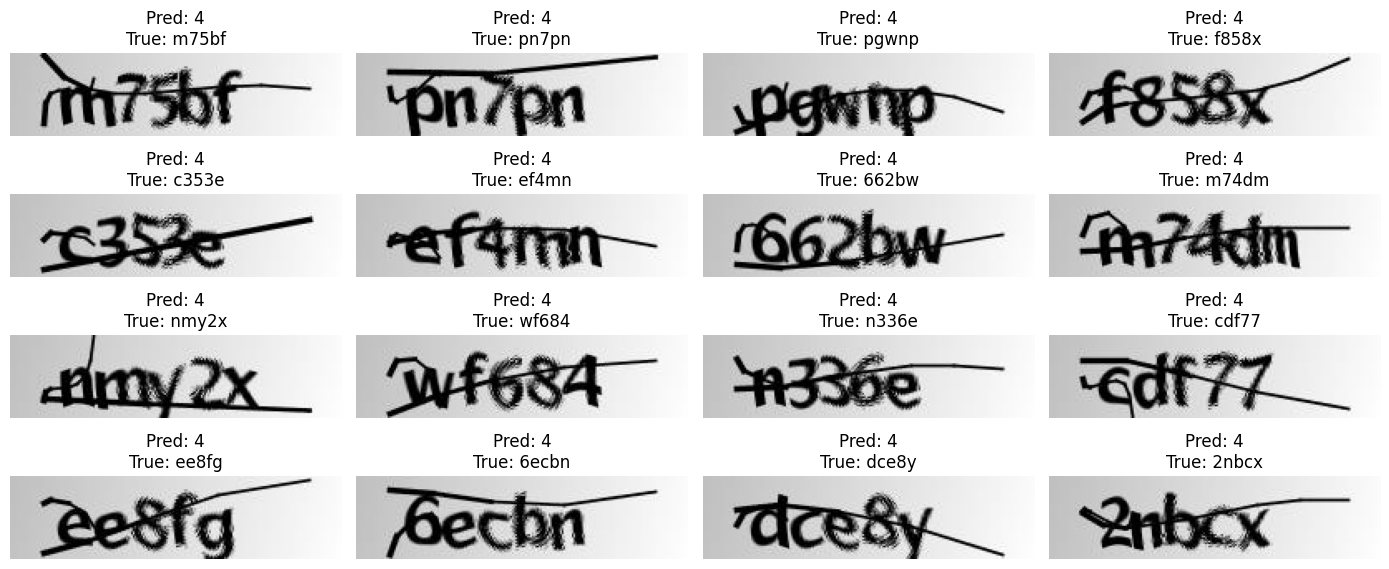

In [20]:
# Modèle pour prédire (image → logits)
prediction_model = keras.Model(
    model.input[0],          # image
    model.layers[-2].output  # Dense softmax
)

def preprocess_only(img_path):
    img = tf.py_function(preprocess_with_opencv, [img_path], tf.float32)
    img.set_shape((img_width, img_height, 1))
    return img

pred_dataset = (
    tf.data.Dataset.from_tensor_slices(x_valid)
    .map(preprocess_only, num_parallel_calls=AUTOTUNE)
    .batch(16)
)

def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]

    decoded = keras.backend.ctc_decode(
        pred,
        input_length=input_len,
        greedy=False,
        beam_width=10,     # ESSENTIEL
        top_paths=1
    )[0][0]

    texts = []
    for seq in decoded:
        seq = tf.boolean_mask(seq, seq > 0)
        text = tf.strings.reduce_join(num_to_char(seq)).numpy().decode("utf-8")
        texts.append(text)
    return texts


preds = prediction_model.predict(pred_dataset)
pred_texts = decode_predictions(preds)

import matplotlib.pyplot as plt
import cv2

n = 16
_, ax = plt.subplots(4, 4, figsize=(14, 6))

for i in range(n):
    img = cv2.imread(x_valid[i], cv2.IMREAD_GRAYSCALE)
    ax[i // 4, i % 4].imshow(img, cmap="gray")

    ax[i // 4, i % 4].set_title(
        f"Pred: {pred_texts[i]}\nTrue: {y_valid[i]}"
    )

    ax[i // 4, i % 4].axis("off")

plt.tight_layout()
plt.show()
